In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import os

In [2]:
from problems.fli import FLI_Prior

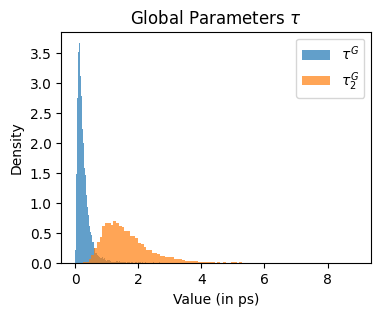

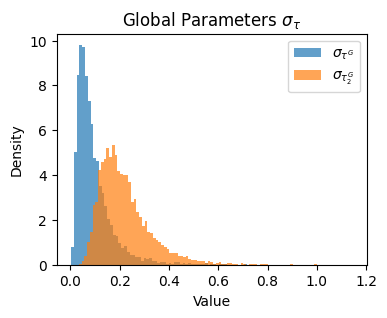

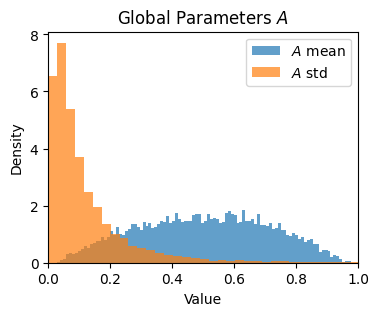

In [3]:
# distribution
n_global_samples = 10000

prior = FLI_Prior()
transform_params = True

sample_dict = prior.sample_single(batch_size=n_global_samples, transform_params=transform_params)
tau_G = sample_dict['global_params'][:, 0]
sigma_tau_G = sample_dict['global_params'][:, 1]
tau_G_2 = sample_dict['global_params'][:, 2]
sigma_tau_G_2 = sample_dict['global_params'][:, 3]
A_mean = sample_dict['global_params'][:, 4]
A_std = sample_dict['global_params'][:, 5]

plt.figure(figsize=(4,3))
plt.title(r'Global Parameters $\tau$')
plt.hist(tau_G, bins=100, alpha=0.7, density=True, label=r'$\tau^G$')
plt.hist(tau_G_2, bins=100, alpha=0.7, density=True, label=r'$\tau^G_2$')
plt.legend()
plt.ylabel('Density')
plt.xlabel('Value (in ps)')
plt.show()

plt.figure(figsize=(4,3))
plt.title(r'Global Parameters $\sigma_{\tau}$')
plt.hist(sigma_tau_G, bins=100, alpha=0.7, density=True, label=r'$\sigma_{\tau^G}$')
plt.hist(sigma_tau_G_2, bins=100, alpha=0.7, density=True, label=r'$\sigma_{\tau^G_2}$')
plt.ylabel('Density')
plt.xlabel('Value')
plt.legend()
plt.show()

plt.figure(figsize=(4,3))
plt.title(r'Global Parameters $A$')
plt.hist(A_mean, bins=100, alpha=0.7, density=True, label=r'$A$ mean')
plt.hist(A_std, bins=100, alpha=0.7, density=True, label=r'$A$ std')
if transform_params:
    plt.xlim(0,1)
plt.legend()
plt.ylabel('Density')
plt.xlabel('Value')
plt.show()

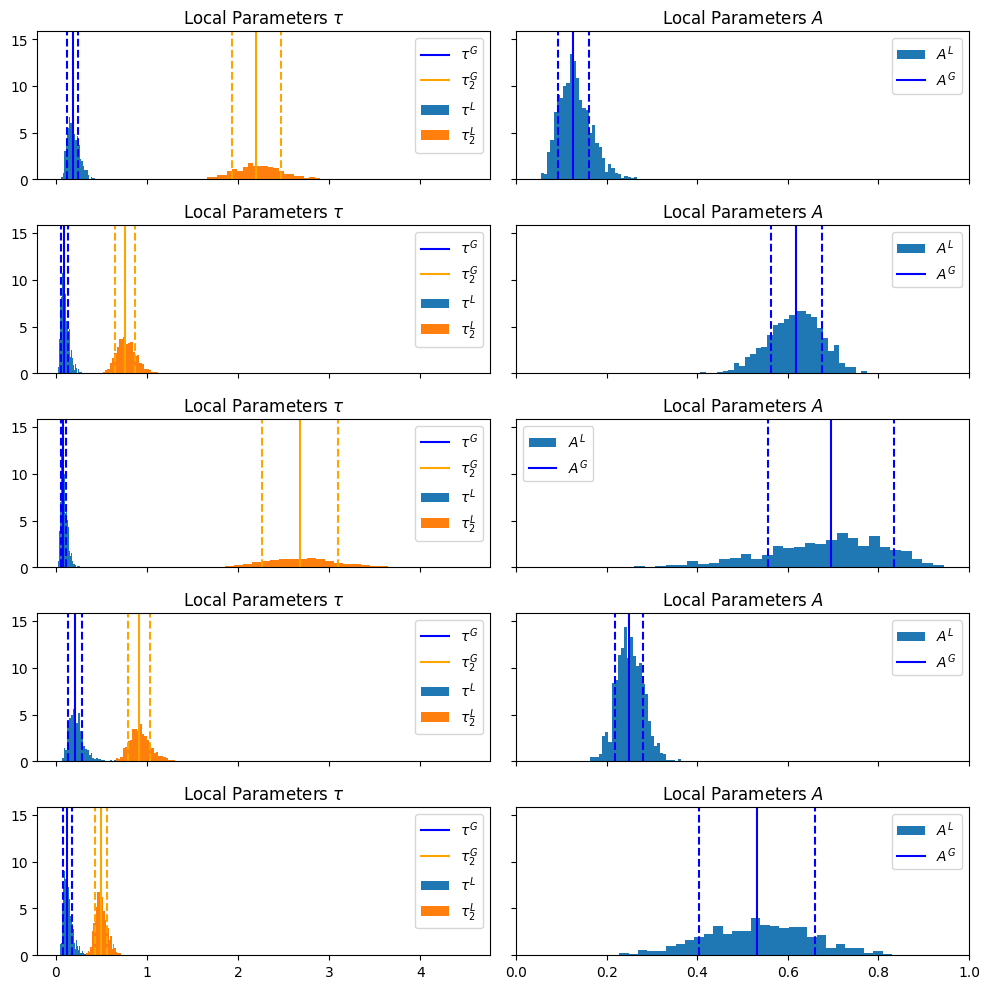

In [4]:
fig, ax = plt.subplots(nrows=5, ncols=2, sharex='col', sharey=True, figsize=(10, 10), tight_layout=True)
for i in range(len(ax)):
    sample_dict = prior.sample_single(batch_size=1, n_local_samples=1000,
                                      transform_params=True)
    tau_G = sample_dict['global_params'][0, 0]
    tau_G_std = sample_dict['global_params'][0, 1]
    tau_G2 = sample_dict['global_params'][0, 2]
    tau_G2_std = sample_dict['global_params'][0, 3]
    A_G = sample_dict['global_params'][0, 4]
    A_G_std = sample_dict['global_params'][0, 5]

    tau_L = sample_dict['local_params'][0, :, 0]
    tau_L_2 = sample_dict['local_params'][0, :, 1]
    A_L = sample_dict['local_params'][0, :, 2]


    ax[i, 0].set_title(r'Local Parameters $\tau$')
    ax[i, 0].axvline(tau_G, color='blue', linestyle='-', label=r'$\tau^G$')
    ax[i, 0].axvline(tau_G-tau_G_std, color='blue', linestyle='--')
    ax[i, 0].axvline(tau_G+tau_G_std, color='blue', linestyle='--')
    ax[i, 0].axvline(tau_G2, color='orange', linestyle='-', label=r'$\tau^G_2$')
    ax[i, 0].axvline(tau_G2-tau_G2_std, color='orange', linestyle='--')
    ax[i, 0].axvline(tau_G2+tau_G2_std, color='orange', linestyle='--')
    ax[i, 0].hist(tau_L, bins=30, density=True, label=r'$\tau^L$')
    ax[i, 0].hist(tau_L_2, bins=30, density=True, label=r'$\tau^L_2$')
    ax[i, 0].legend()

    ax[i, 1].set_title(r'Local Parameters $A$')
    ax[i, 1].hist(A_L, bins=30, density=True, label=r'$A^L$')
    ax[i, 1].axvline(A_G, color='blue', linestyle='-', label=r'$A^G$')
    ax[i, 1].axvline(A_G-A_G_std, color='blue', linestyle='--')
    ax[i, 1].axvline(A_G+A_G_std, color='blue', linestyle='--')
    ax[i, 1].set_xlim(0, 1)
    ax[i, 1].legend()
plt.show()

In [6]:
def decay_gen(img, irf, noise, gw, n_local_samples):  # IRF, Gate_width (in ps)
    a, b = np.shape(img)
    a1, b1, c1 = np.shape(irf)
    t = np.linspace(0, c1* (gw  * (10 ** -3)), c1)
    t_minus = np.multiply(t, -1)
    prior_samples = prior.sample_local(n_local_samples)
    tau_L, tau_L_2, A_L = prior_samples['tau_L'], prior_samples['tau_L_2'], prior_samples['A_L']
    tau1 = np.reshape(tau_L, (a, b))
    tau2 = np.reshape(tau_L_2, (a, b))
    frac1 = np.reshape(A_L, (a, b))
    frac2 = 1 - frac1
    A = np.zeros([c1])
    B = np.zeros([c1])
    i = np.random.randint(a)
    j = np.random.randint(b)
    if tau1[i, j] != 0:
        A = np.multiply(frac1[i, j], np.exp(np.divide(t_minus, tau1[i, j])))
    if tau2[i, j] != 0:
        B = np.multiply(frac2[i, j], np.exp(np.divide(t_minus, tau2[i, j])))
    dec = A + B
    irf_out = norm1D(irf[i,j, :])
    dec_conv = conv_dec(norm1D(dec), irf_out)
    dec_conv = norm1D(np.squeeze(dec_conv))*img[i,j]
    dec_conv += noise[i,j,:]
    return dec_conv, tau1[i, j], tau2[i, j], frac1[i, j]

def tiff2tpsfs(p):
    k = os.listdir(p)
    le = len(k)
    img0 = mpimg.imread(os.path.join(p, k[0]))
    (a, b) = np.shape(img0)
    tpsfs = np.zeros([a, b, le - 1])
    for count, file in enumerate(os.listdir(p)):
        # Check whether file is in text format or not
        if file.endswith(".tif"):
            imt = mpimg.imread(os.path.join(p, file))
            tpsfs[:, :, count] = imt
    inten = np.sum(tpsfs, axis=2)
    return tpsfs, inten

def norm1D(fn):
    if np.amax(fn) == 0:
        nfn = fn
    else:
        nfn = np.divide(fn, np.amax(fn))
    return nfn

def conv_dec(dec, irf):
    c = np.shape(dec)
#     conv = np.zeros((2 * c - 1,1))
    conv = np.convolve(dec, irf)
    conv = conv[:len(dec)]
    return conv

def random_crop(array, crop_size):
    A, B, C = array.shape
    a, b = crop_size

    if a > A or b > B:
        raise ValueError("Crop size must be smaller than or equal to the original array size")

    # Randomly select the top-left corner of the crop
    top = np.random.randint(0, A - a + 1)
    left = np.random.randint(0, B - b + 1)

    # Crop the subarray
    return array[top:top + a, left:left + b, :]

In [7]:
ns = np.load('problems/FLI/noise_micro.npy')
pIRF = np.load('problems/FLI/irf_micro.npy')

(512, 512, 256)


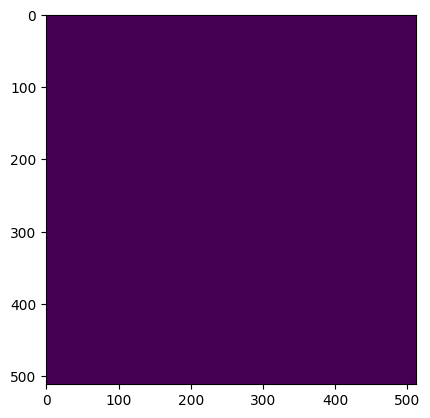

302
107


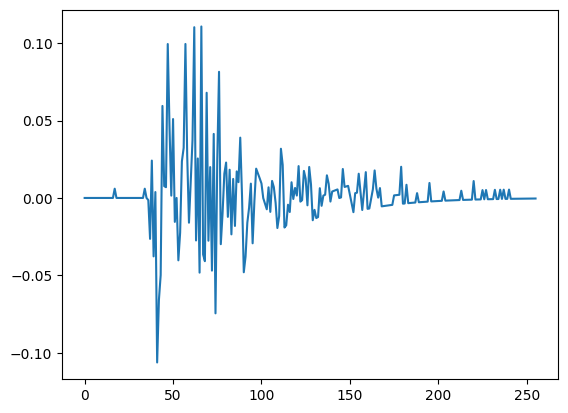

In [8]:
print(pIRF.shape)
plt.imshow(np.sum(pIRF, axis=2))
plt.show()
a = np.random.randint(ns.shape[0])
b = np.random.randint(ns.shape[1])
print(a)
print(b)
plt.plot(ns[a,b,:])
plt.show()

### For Data generation

In [9]:
data_dict = prior.sample_single(batch_size=1, n_local_samples=25)

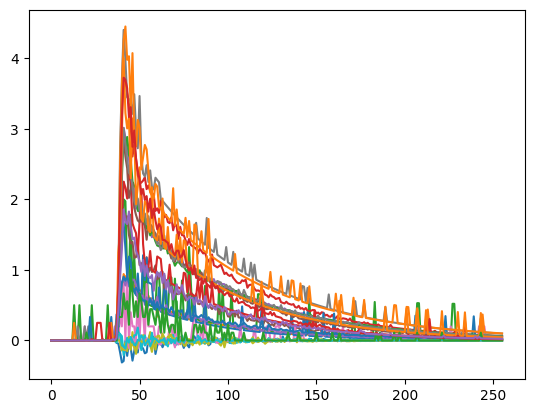

In [10]:
plt.plot(data_dict['data'][0].T)
plt.show()

In [ ]:
plt.figure()
for i in range(F_dec_conv.shape[0]):
   
    slice_data = F_dec_conv[i, :]  # Extract the data along axis 3 for (i, j)

    plt.plot( F_dec_conv[i, :]) # plot the 201 values

    plt.grid(True)
plt.show()